Machine learning INF284 Group Exam: Markus, Nikita, Bo og Andre

# Task 1 Machine Learning on Mushroom Dataset
## Importing Modules


Here we import all of our necessary libraries. Sklearn for predicitive data analysis, classification, regression, clustering and more. Pandas for data analysis and data manipulation and so forth. We use numpy for numerical computing, this provides tools for working with arrays and matrices and other numerical data. Dython we use for work on nominal data. Matplotlib is used for data visualization, seaborn is used for informative and aestetic plots.


In [147]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from dython.nominal import associations
import matplotlib.pyplot as plt
from dython import nominal



from sklearn.model_selection import train_test_split
pd.options.display.max_columns = 500
pd.set_option('display.max_rows', 200)

## Loading Data

In [148]:
df = pd.read_table('agaricus-lepiota.csv', delimiter=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


## Pre-processing

We check for any duplicates in our dataframe ("df"), this is important due to the fact that duplicates can inflate performance by overfitting. However, we read that there are 0 duplicates in our 8124 rows.

In [149]:
duplicates = df.duplicated().sum()
count = df.shape[0]
print(f'{duplicates} duplicate rows in {count} rows')

0 duplicate rows in 8124 rows


In [150]:
column_labels = [
    'class', 'cap shape', 'cap surface', 'cap color', 'bruised', 'odor',
    'gill attachment', 'gill spacing', 'gill size', 'gill color', 
    'stalk shape', 'stalk root', 'stalk surface above ring',
    'stalk surface below ring', 'stalk color above ring',
    'stalk color below ring', 'veil type', 'veil color', 'ring number',
    'ring type', 'spore print color', 'population', 'habitat'
]

df.columns = column_labels

We use the classifications from the "agaricus-lepiota" text file. We can now see how the "1" have turned into "class", and the other numbers have turned into other descriptive words.

In [151]:
df.head()

,class,cap shape,cap surface,cap color,bruised,odor,gill attachment,gill spacing,gill size,gill color,stalk shape,stalk root,stalk surface above ring,stalk surface below ring,stalk color above ring,stalk color below ring,veil type,veil color,ring number,ring type,spore print color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [152]:
df['class'].replace(['e', 'p'], [0, 1], inplace=True)
df['stalk root'].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk root, dtype: int64

This code replaces the values in 'class'. It replaces 'e' (edible) with 0 and 'p' (poisonous) with 1. We change them from categorical to numerical.  
We see that there are alot of the mushrooms that have "stalk root" type "?", 30.5% of the mushrooms have "?" as its stalk root.

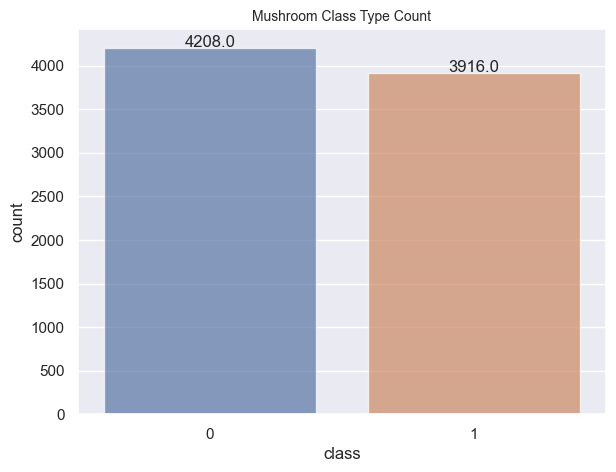

In [153]:
plt.rcParams['figure.figsize']=15,5
plt.subplot(121)
plt.title('Mushroom Class Type Count', fontsize=10)
s = sns.countplot(x = "class", data = df, alpha=0.7)
for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

Here we show the count difference between edible (0) and poisonous (1) mushrooms. We see that the dataset is very balanced between classes.

In [154]:
df['veil type'].value_counts()

p    8124
Name: veil type, dtype: int64

We count the veil type as well and find that all the mushrooms have the type. We therefore decide to drop it, as it wont impact performance.

In [155]:
df.columns.drop(['stalk root'])
df.columns.drop(['veil type'])

Index(['class', 'cap shape', 'cap surface', 'cap color', 'bruised', 'odor',
       'gill attachment', 'gill spacing', 'gill size', 'gill color',
       'stalk shape', 'stalk root', 'stalk surface above ring',
       'stalk surface below ring', 'stalk color above ring',
       'stalk color below ring', 'veil color', 'ring number', 'ring type',
       'spore print color', 'population', 'habitat'],
      dtype='object')

In [156]:
print(len(df.columns))

23


Further, we calculate the Theil's U statistic between the target ('class') and each feature in the DataFrame.

Theil's U is a measure of the strength of association between two categorical variables. It ranges from 0 to 1, where 0 indicates no association and 1 indicates a strong association. This is useful for identifying which features are most informative for predicting the target variable.

Finally, we create a heatmap visualization of the results using the sns.heatmap() function from the Seaborn library. The heatmap is annotated with the correlation for each feature and target pair.

c:\Users\Bo Bang-Hansen\PycharmProjects\oblig\venv\lib\site-packages\dython\nominal.py:219: RuntimeWarning: Rounded U = -1.6032076067317889e-16 to 0.0. This is probably due to floating point precision issues.
  warnings.warn(


<Axes: >

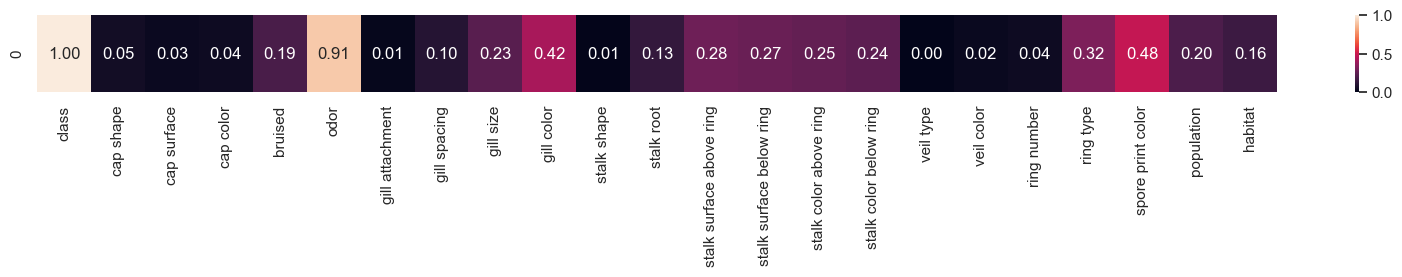

In [157]:
theil_data = [[nominal.theils_u(df["class"], df[col]) for col in df]]
plt.figure(figsize=(20,1))
sns.heatmap(theil_data, annot=True, fmt='.2f', xticklabels=df.columns)

From this heatmap we can deduce that odor has a very close correlation to the precense of poison in the mushroom. Now we can take a closer look at odor to see how it correlates with the presence of poison.

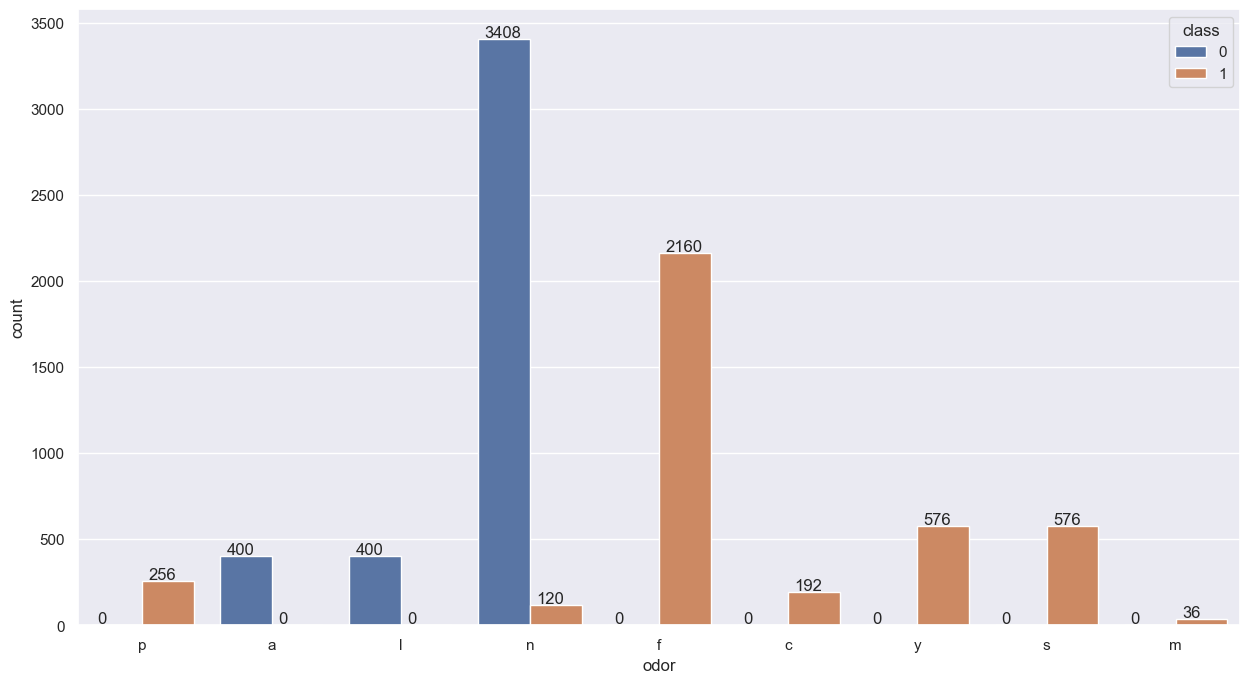

In [158]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='odor',hue='class',data=df)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0    
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

In this graph we see that the presence of "odor f", meaning foul odor guarantees the presence of poison, there are a multitude of other smells that also guarantees poison. However "odor n", meaning no odor is weighted towards non-poisonous, however there are 120 instances of mushrooms that smell nothing that also are poisonous.

### One-Hot Encoding

This code snippet performs one-hot encoding for all categorical features in the dataframe, except for the target variable column "class". 

This process is done so that we convert categorical features into a numerical format, here we avoid assigning an arbitrary ordering to the categorical values that might not be meaningful for the model. And as there is no natural ordering for things like 'cap shape' or colors one-hot is well suited for this task.

In [159]:
for column in df.columns.drop(["class"]):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df.drop([column], axis=1, inplace=True)

In [160]:
df.head()

,class,cap shape_b,cap shape_c,cap shape_f,cap shape_k,cap shape_s,cap shape_x,cap surface_f,cap surface_g,cap surface_s,cap surface_y,cap color_b,cap color_c,cap color_e,cap color_g,cap color_n,cap color_p,cap color_r,cap color_u,cap color_w,cap color_y,bruised_f,bruised_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill attachment_a,gill attachment_f,gill spacing_c,gill spacing_w,gill size_b,gill size_n,gill color_b,gill color_e,gill color_g,gill color_h,gill color_k,gill color_n,gill color_o,gill color_p,gill color_r,gill color_u,gill color_w,gill color_y,stalk shape_e,stalk shape_t,stalk root_?,stalk root_b,stalk root_c,stalk root_e,stalk root_r,stalk surface above ring_f,stalk surface above ring_k,stalk surface above ring_s,stalk surface above ring_y,stalk surface below ring_f,stalk surface below ring_k,stalk surface below ring_s,stalk surface below ring_y,stalk color above ring_b,stalk color above ring_c,stalk color above ring_e,stalk color above ring_g,stalk color above ring_n,stalk color above ring_o,stalk color above ring_p,stalk color above ring_w,stalk color above ring_y,stalk color below ring_b,stalk color below ring_c,stalk color below ring_e,stalk color below ring_g,stalk color below ring_n,stalk color below ring_o,stalk color below ring_p,stalk color below ring_w,stalk color below ring_y,veil type_p,veil color_n,veil color_o,veil color_w,veil color_y,ring number_n,ring number_o,ring number_t,ring type_e,ring type_f,ring type_l,ring type_n,ring type_p,spore print color_b,spore print color_h,spore print color_k,spore print color_n,spore print color_o,spore print color_r,spore print color_u,spore print color_w,spore print color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


Here we see the effects of one-hot, we have split all the categories and now have binary values for each, '1' indicating the presence of said feature and '0' denoting the absence. 

In [161]:
target = df["class"]
data = df.drop("class", axis=1)
print(target.shape)
print(data.shape)
data.head()

(8124,)
(8124, 117)


,cap shape_b,cap shape_c,cap shape_f,cap shape_k,cap shape_s,cap shape_x,cap surface_f,cap surface_g,cap surface_s,cap surface_y,cap color_b,cap color_c,cap color_e,cap color_g,cap color_n,cap color_p,cap color_r,cap color_u,cap color_w,cap color_y,bruised_f,bruised_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill attachment_a,gill attachment_f,gill spacing_c,gill spacing_w,gill size_b,gill size_n,gill color_b,gill color_e,gill color_g,gill color_h,gill color_k,gill color_n,gill color_o,gill color_p,gill color_r,gill color_u,gill color_w,gill color_y,stalk shape_e,stalk shape_t,stalk root_?,stalk root_b,stalk root_c,stalk root_e,stalk root_r,stalk surface above ring_f,stalk surface above ring_k,stalk surface above ring_s,stalk surface above ring_y,stalk surface below ring_f,stalk surface below ring_k,stalk surface below ring_s,stalk surface below ring_y,stalk color above ring_b,stalk color above ring_c,stalk color above ring_e,stalk color above ring_g,stalk color above ring_n,stalk color above ring_o,stalk color above ring_p,stalk color above ring_w,stalk color above ring_y,stalk color below ring_b,stalk color below ring_c,stalk color below ring_e,stalk color below ring_g,stalk color below ring_n,stalk color below ring_o,stalk color below ring_p,stalk color below ring_w,stalk color below ring_y,veil type_p,veil color_n,veil color_o,veil color_w,veil color_y,ring number_n,ring number_o,ring number_t,ring type_e,ring type_f,ring type_l,ring type_n,ring type_p,spore print color_b,spore print color_h,spore print color_k,spore print color_n,spore print color_o,spore print color_r,spore print color_u,spore print color_w,spore print color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


Now we have divided our data, we have the target being 'class', we have also counted all the features after one-hot and we find that we now have 117 different features.

## Model Training

First, the data is divided into train, test, and validation sets using train-test-split.

Now we want to find out how to best fit the data for the models, our first model will be KNeighborsClassifier.
K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for classification and regression.
In the case of classification, given a new data point, the algorithm finds the k closest data points in the training set and assigns the class that appears the most among the k nearest neighbors as the predicted class for the new data point. 

In [162]:
X_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Minimum error:- 0.0 at Neighbors = 0


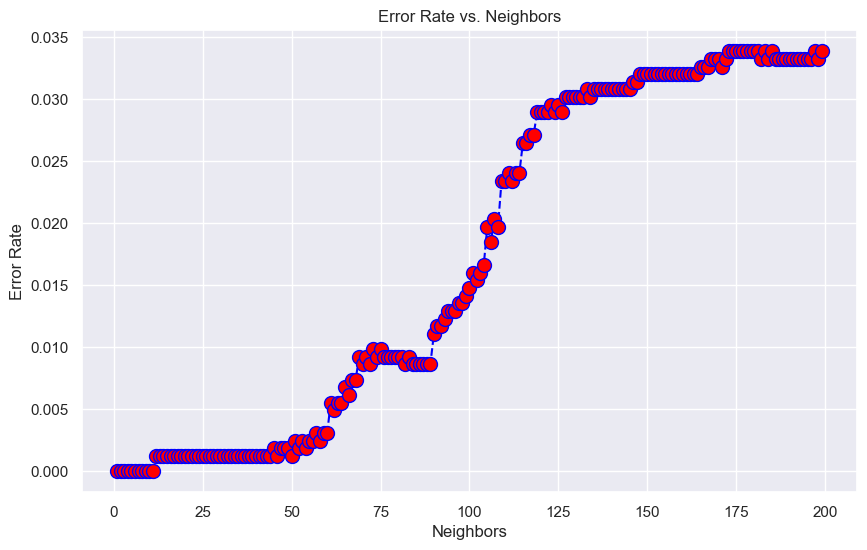

In [163]:
error_rate = []
for i in range(1,200):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(x_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,200),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Neighbors')
plt.xlabel('Neighbors')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at Neighbors =",error_rate.index(min(error_rate)))

We use a graph to show where K-value or 'neighbors' lead to 0.00 error, we find that there are multiple points along the x-axis, or 'neighbor-axis' that lead to 0.00 error. However using this miniscule amount of neighbors may, and in this case probably will lead to overfitting as the dataset is so large. 

Validation set is used to to tweak our hyper paramaters wich in this case is 'n_neighbors'. A low 'n_neighbors' leads to overfitting, and a high 'n_neighbors' can lead to the alghorithm missing important patterns.

In [164]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)

val_score = knn.score(X_val, y_val)

print(f"Validation score: {val_score}")

Validation score: 0.9961538461538462


In [165]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)
pred = knn.predict(x_test)
score = knn.score(x_test, y_test)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
print(f"KNeighbor: {score}")

KNeighbor: 0.9667692307692307


We therefore  in the test data increase neighbors to 200, and find our score to be 96.67%. We do this due to fact that our dataset is large, and we dont want to overfit, nor do we want to miss any patterns. 

In [166]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
print(f"Logistic Regression: {log_model.score(x_test, y_test)}")

Logistic Regression: 1.0


With the LogisticRegression model, we reach 100% percent, and we also reach 100% for the MLPClassifier. 

In [167]:
nn_model = MLPClassifier(hidden_layer_sizes=(128, 128))
nn_model.fit(X_train, y_train)
print(f"Neural Network: {nn_model.score(x_test, y_test)}")

Neural Network: 1.0


We belive that the machine learning models reaches this astoundingly high percentage due to the fact that the dataset is so well balanced between edible and poisonous and because the data set is quite large. 

In [168]:
y_pred = nn_model.predict(x_test)
print(y_pred)

[0 1 1 ... 1 1 1]


In [169]:
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[843   0]
 [  0 782]]


We print out a confusion matrix for further clarification, this shows that in the prediction, our confuison matrix has no false postives, denoted by the '0' in the first line, and no false negatives, denoted by the '0' in the second line. Here it is important to remember that false negatives would not be as bad as false positives, this is due to the fact that if the model shows that a harmless mushroom is harmless you would not eat it and no harm would be caused. However a false negative would cause you to potentially ingest it, but it would be poisonous, and this would lead to harm. 

In [170]:
corr = df.corr()

corr = pd.DataFrame(corr["class"])
corr.sort_values(by=['class'], ascending=False)

,class
class,1.000000
odor_f,0.623842
stalk surface above ring_k,0.587658
stalk surface below ring_k,0.573524
gill size_n,0.540024
gill color_b,0.538808
bruised_f,0.501530
spore print color_h,0.490229
ring type_l,0.451619
population_v,0.443722


Here we print out all the correlations to give a broader understanding of how each feature of the mushroom correlates with class. This ranges between -1 and 1, the lower the number the more negative correlation it has with poison. As shown in the diagram above this seems to be correct as 'odor_n' is reasonably safe with a correlation of -0.785. That means that it is a healthy chance to eat one of these odorless mushrooms without being poisoned, however there is still a slight chance, we observed that 120 of the mushrooms with this feature still obtain poison.

# Task 2 Sentiment analysis 

# Task 3 Convolutional neural networks

In this task, the assignment is about training a convolutional neural network (CNN) as a binary classifier from the dataset that we have been provided with. This is a CIFAR-10 dataset that consists of 60000 images that are 32x32 colored images and will identify one of the following categories; airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Each of these has 6000 images that are divided into 50000 for the training model and 10000 for the testing model.

Info Box: Importing Required Libraries

In the following code block, we are importing the necessary libraries and modules to build and train the convolutional neural network (CNN) for binary image classification of task 3 using the Dataset of CIFAR-10. The following is a numerated list of imports with further explanations.

1. tensorflow: TensorFlow is an open-source machine learning library that helps us define and train neural network models.
2. VGG16: VGG16 is a pre-trained CNN architecture, which has proven to be effective for various image recognition tasks. We will use this as the base model for our classifier.

While researching for this assignment we found a couple of different pre-trained CNN models we could use for this project. Some of the choices were ResNet-50/101/152, Inception-v3/v4, MobileNetV1/V2/V3. A decision was made not to use these because of the computing power that would be unsatisfactory for some systems with the amount of layers that the models have. We landed upon the VGG16 model that is a deep CNN model that has 16 layers. It is a less complex model compared to the previous one we have mentioned, but it is more complex then a 3-5 layer CNN. We chose VGG16 at first because we ran into some errors while trying to create our own 3-5 layer CNN using a pre-trained CNN model that has strong performance in particular image classification.

3. image: The image module from the Keras preprocessing library helps us load and preprocess images from our dataset.
4. Model: This class allows us to create custom models by specifying the input and output layers.
5. Dense and GlobalAveragePooling2D: These are Keras layers that we'll use to modify the VGG16 model for our specific task.
6. Adam: The Adam optimizer is an optimization algorithm that helps us train our neural network.
7. numpy: NumPy is a library for numerical computing in Python. We'll use it for handling arrays and mathematical operations.
8. os: The os module provides a way of using operating system dependent functionality like reading or writing to the file system.
9. pickle: This module is used for serializing and de-serializing Python objects. We will use it to load the CIFAR-10 dataset.
10. matplotlib.pyplot: Matplotlib is a plotting library, and we will use it to visualize our dataset and training results. We will be plotting accuracy and validation loss to see when and if the data plateaus once we start training it.

In [171]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

Loading CIFAR-10 Dataset

In the following code block, we define a function called unpickle that is going to load our CIFAR-10 dataset files. The dataset is stored in a serialized format using the Python pickle module. This function accepts a file path as input and returns a dictionary containing the loaded data.

1. file: The file path of the CIFAR-10 dataset file to load.
2. fo: A file object created using the open() function to read the contents of the dataset file.
3. dict: A dictionary object containing the deserialized contents of the dataset file.

We use this function by simply passing the file path of a CIFAR-10 dataset file to it, and it will return a dictionary containing the loaded data.

In [ ]:
# Define the function to load our dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Loading and Preprocessing CIFAR-10 Dataset

Further we load the data by defining a function called load_cifar10_data to load and preprocess the CIFAR-10 dataset. This function accepts the path to the data directory containing the dataset files and returns the preprocessed training and testing data along with their corresponding labels.

The function performs the following steps:

1. Iterate through the data batches 1 to 5 and load each batch using the unpickle function.
2. Stack the training data from all batches vertically using np.vstack.
3. Load the testing data using the unpickle function.
4. Reshape the training and testing data to match the desired dimensions (number of images, height, width, and channels) using numpy.reshape.
5. Rearrange the axes to match the format expected by the TensorFlow library using numpy.rollaxis.
6. Convert the training and testing labels to NumPy arrays.

We use this function by passing the path to the data directory containing the CIFAR-10 dataset files, and it will return the preprocessed training and testing data along with their corresponding labels.

In [ ]:
# Load and preprocess the dataset
def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dict = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        if i == 1:
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

Loading CIFAR-10 Dataset into Variables

Further we are using the load_cifar10_data function to load and preprocess the CIFAR-10 dataset. We provide the data directory containing the dataset files as an argument to the function.

The function returns four arrays:

1. x_train: The preprocessed training data, a NumPy array of shape (number of training images, height, width, channels).
2. y_train: The training labels, a NumPy array of shape (number of training images,).
3. x_test: The preprocessed testing data, a NumPy array of shape (number of testing images, height, width, channels).
4. y_test: The testing labels, a NumPy array of shape (number of testing images,).

We store these arrays in the corresponding variables to use later in our neural network model training process.

In [ ]:
data_dir = './cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

Preprocessing and Normalizing Input Data

In this code block, we perform further preprocessing on the input data and normalize the pixel values for both the training and testing sets.

We divide the pixel values by 255 to scale them to the range [0, 1]. This normalization helps improve the training process by ensuring that the input values are within a similar scale.

We choose a category (in this case, 0) for our binary classification task.

We convert the class labels for both training and testing sets to one-hot encoded vectors using the tf.keras.utils.to_categorical function. One-hot encoding is a representation method where the index of the target class is set to 1 and the remaining indices are set to 0. This is a preprocessing step for multi-class classification problems.

By normalizing the input data and converting the class labels to one-hot encoding, we prepare our dataset for training the CNN model.

In [ ]:
# Preprocess input data, and normalize the input data 
x_train = x_train / 255.0
x_test = x_test / 255.0

chosen_category = 0

# Convert class labels to one-hot encoding
y_train = np.where(y_train == chosen_category, 1, 0)
y_test = np.where(y_test == chosen_category, 1, 0)

Plotting Validation Loss

Here we define a function called plot_validation_loss to visualize the validation loss during the training process. This function accepts the training history object returned by the fit method when training a Keras model and generates a plot of the validation loss over epochs.

The function performs the following steps:

1. Use the plt.plot function to create a line plot of the validation loss stored in history.history['val_loss'].
2. Set the title, x-axis label, and y-axis label for the plot using plt.title, plt.xlabel, and plt.ylabel functions.
3. Add a legend to the plot using the plt.legend function, specifying the location of the legend as the upper right corner.
4. Display the plot using the plt.show function.

We are going to use this function to analyze the training process and identify any issues, such as overfitting or underfitting, based on the validation loss curve.

In [ ]:
# Function to plot validation loss
def plot_validation_loss(history):
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Validation'], loc='upper right')
    plt.show()

Plotting Model Accuracy

Here we define a function `plot_accuracy(history)` to plot the training and validation accuracy over training epochs:

1. The history variable contains training information, including training and validation accuracy per epoch.

2. The `plot_accuracy()` function creates a line plot using Matplotlib, displaying the training and validation accuracy over epochs. It sets the x-axis label as "Epoch," the y-axis label as "Accuracy," and the title as "Model Accuracy." The legend indicates that the two plotted lines represent the training and validation accuracy.

By examining the plot, we are going to observe the model's performance during training, and identify potential overfitting or underfitting issues based on the gap between the training and validation accuracy curves.

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Loading the Pre-trained VGG16 Model

In the following code block we load the pre-trained VGG16 model using the VGG16 function from the tensorflow.keras.applications module. We will use this pre-trained model as the base for our binary image classifier.

The VGG16 function accepts the following arguments:

1. weights: The pre-trained weights to load. In this case, we use the 'imagenet' weights, which were trained on the ImageNet dataset.
2. include_top: A boolean value indicating whether to include the fully connected layers at the top of the network. We set this to False to exclude the original classification layer, as we will add our custom binary classification layer later.
3. input_shape: The shape of the input tensor. We provide a tuple with the desired input shape (32, 32, 3) since the CIFAR-10 images have a resolution of 32x32 pixels and 3 color channels.

After loading the VGG16 model, we store it in the base_model variable, which we will use to build our custom binary classifier.

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

2023-05-01 13:16:10.985352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modifying the VGG16 Model for Binary Classification

In this code block, we modify the pre-trained VGG16 model to create our binary image classifier. We follow these steps:

We add a global spatial average pooling layer by taking the output of the base VGG16 model (base_model.output) and pass it through a GlobalAveragePooling2D layer. This layer reduces the spatial dimensions of the feature maps by computing the average of all values in each channel. This operation significantly reduces the number of parameters and helps prevent overfitting the model.

Then we add a fully connected layer by adding a Dense layer with 1024 units and a ReLU activation function. This layer will learn higher-level features from the pooled feature maps.

We finaly change the output layer to have a single unit with a sigmoid activation function, which is appropriate for binary classification. The sigmoid activation function outputs a value between 0 and 1, representing the probability that the input image belongs to our chosen category.

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add the final output layer for 10-class classification
# predictions = Dense(10, activation='softmax')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

Fine-tuning the Custom Binary Classifier Model

We fine-tune the binary classifier model on our dataset by following these steps:

1. Freeze the Convolutional Layers: We freeze all the convolutional layers of the base VGG16 model by setting their trainable attribute to False. This ensures that the weights of the convolutional layers remain unchanged during training, and only the fully connected layers we added are trained. This speeds up training and leverages the pre-trained features learned by the VGG16 model.

2. Compile the Model: We compile the model using the Adam optimizer with a learning rate of 0.0001 and the correct loss function for binary classification, 'binary_crossentropy'. We also use 'accuracy' as the evaluation metric.

3. Train the Model: We train the model on the preprocessed CIFAR-10 dataset using the fit method. We provide the training data, x_train and y_train, and set the number of epochs to 5. We also specify the validation data, x_test and y_test, to monitor the model's performance on unseen data.

After training, the model's weights are updated, and the training history is stored in the history variable. This history can be used to plot the training and validation accuracy and loss over time, providing insights into the model's performance and potential overfitting.

In [ ]:
# Fine-tune only the top layers (freeze all convolutional layers)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
1563/1563 [==============================] - 182s 116ms/step - loss: 0.2051 - accuracy: 0.9216 - val_loss: 0.1824 - val_accuracy: 0.9307
Epoch 2/3
1563/1563 [==============================] - 185s 118ms/step - loss: 0.1748 - accuracy: 0.9340 - val_loss: 0.1719 - val_accuracy: 0.9339
Epoch 3/3
1563/1563 [==============================] - 185s 118ms/step - loss: 0.1654 - accuracy: 0.9370 - val_loss: 0.1650 - val_accuracy: 0.9373


Plotting the Validation Loss

We plot the validation loss over the training epochs using our function `plot_validation_loss(history)` that we made earlier.

The history variable contains the training information, including the validation loss for each epoch.

The plot_validation_loss function takes this history as input and creates a line plot using the Matplotlib library. It sets the x-axis label as "Epoch," the y-axis label as "Loss," and the title as "Validation Loss." The legend indicates that the plotted line represents the validation loss.

By examining the validation loss plot, you can observe how well the model generalizes to unseen data. If the validation loss decreases over time and converges to a minimum value, it indicates that the model is learning effectively. If the validation loss starts to increase while the training loss continues to decrease, it may suggest overfitting, and we should consider regularization techniques or early stopping to prevent overfitting. 

We used 5 to 25 epochs and didn't see the model converge while still giving us the correct binary classification of an image

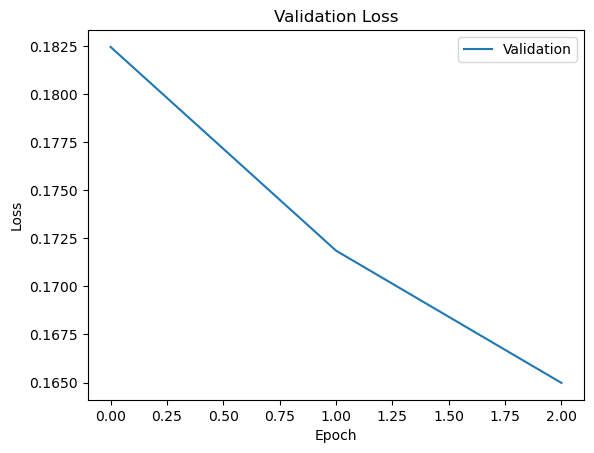

In [ ]:
# Plotting the validation loss
plot_validation_loss(history)

Plotting Model Accuracy

Here we execute our plot_accuracy(history) function to visualize the training and validation accuracy over the training epochs.

1. The history variable contains training information, including training and validation accuracy per epoch.

2. The `plot_accuracy()` function plots the training and validation accuracy over epochs, displaying the model's performance during training.

By examining the plot, you can observe the model's performance and identify potential overfitting or underfitting issues based on the gap between the training and validation accuracy curves. A well-performing model should have a smaller gap and high accuracy on both sets, suggesting effective learning and good generalization to unseen data.

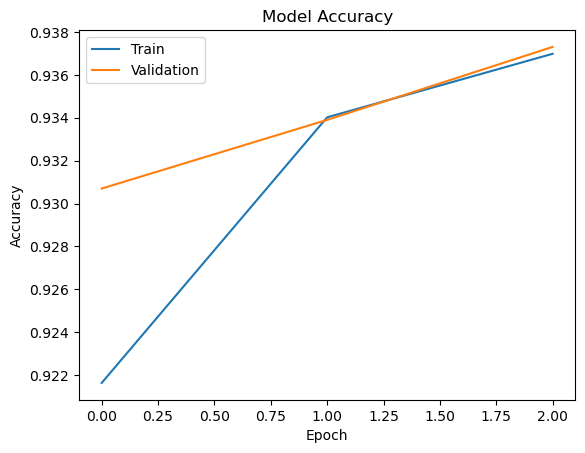

In [ ]:
# Plotting the accuracy
plot_accuracy(history)

Loading and Preprocessing a New Image

We Load and preprocess a new image before using the model to classify it:

1. Load the New Image: We use the `image.load_img()` function from Keras' image module to load the new image, resizing it to match the model's input size (32 x 32 pixels).

2. Convert Image to NumPy Array: We convert the PIL Image object to a NumPy array using the `image.img_to_array()` function.

3. Expand Dimensions: We add an extra dimension to the image array using `np.expand_dims()`, creating a batch with only one image. This is required because the model expects input data in batches.

4. Normalize the Image: We normalize the image by dividing its pixel values by 255.0, ensuring the new image's pixel values are in the same range as the training data (0 to 1).

Now, the new image is ready to be passed through the model for classification.

In [ ]:
# Load a new image and preprocess it
new_image_path = './new_images/picture_3.png'# Here is the pathing for the image so if you want to add an image just past it into this folder and change the name.
new_image = image.load_img(new_image_path, target_size=(32, 32))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0


Predicting the Class of a New Image

We use the trained model to predict the class of the preprocessed new image:

1. Predict the Class: We use the `model.predict()` method to predict the class of the new image. The method returns the predicted probability for the positive class (the chosen category).

2. Determine the Predicted Class: We set a threshold of 0.5 to decide the predicted class. If the predicted probability is greater than 0.5, we assign the positive class (1); otherwise, we assign the negative class (0).

Now, `predicted_class` holds the predicted class of the new image, indicating whether the model classified the image as being part of the chosen category or not.

In [ ]:
# Predict the class of the new image
prediction = model.predict(new_image)
predicted_class = 1 if prediction[0][0] > 0.5 else 0


1/1 [==============================] - 0s 112ms/step


Displaying the Predicted Class

We display the predicted class of the new image:

1. Create a List of Categories: We define a list called `categories`, which contains two elements: 'not airplane' and 'airplane' for our binary classifier. These elements correspond to the negative class (0) and the positive class (1), respectively.

2. Print the Predicted Class: We use the `print()` function to display the predicted class of the new image. By indexing the `categories` list with the `predicted_class` variable, we obtain a human-readable string that represents the predicted class.

This provides a user-friendly output, indicating whether the model classified the new image as being part of the chosen category (airplane) or not.

In [ ]:
categories = ['not airplane', 'airplane']
print(f"The image is predicted to be {categories[predicted_class]}.")

The image is predicted to be not airplane.
